In [7]:
#better to shuffle image names in the dir
import random
import cv2
import numpy as np
import os
import tensorflow as tf
ims = os.listdir('./images')
random.shuffle(ims)
msk = [i.replace("image","mask") for i in ims]
ims = ['./images/'+x for x in ims]
msk = ['./masks/'+x for x in msk]
print(len(ims),len(msk))

1944 1944


654


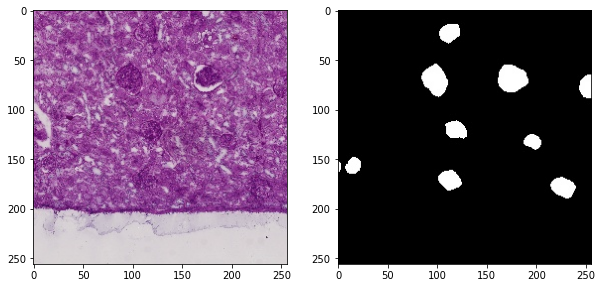

In [17]:
import random
fig, axs = plt.subplots(1,2,figsize=(10,10))
num = random.randint(1,len(ims))
print(num)
m = cv2.imread(ims[num])
n = cv2.imread(msk[num])
axs[0].imshow(m)
axs[1].imshow(n)

In [ ]:
unique, counts = np.unique(n, return_counts=True)
print(dict(zip(unique, counts)))

In [3]:
from tensorflow.keras.utils import get_custom_objects
def dice_coeff(y_true, y_pred):
        # add epsilon to avoid a divide by 0 error in case a slice has no pixels set
        # we only care about relative value, not absolute so this alteration doesn't matter
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
  
get_custom_objects().update({"dice": dice_loss})

In [4]:
%pip install git+https://github.com/qubvel/segmentation_models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
sm.__version__

BACKBONE = 'efficientnetb3'#'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-m6swc71e
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-m6swc71e
  Running command git submodule update --init --recursive -q
Note: you may need to restart the kernel to use updated packages.
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [34]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet',input_shape=(256, 256, 3))
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-5), loss = 'dice', metrics=[dice_coeff])
#model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics='accuracy')
mcp_save = ModelCheckpoint('./mdl_wts.h5', save_best_only=True, monitor='val_loss', mode='min')
callback = EarlyStopping(monitor='loss',
                           min_delta=0,
                           patience=2,
                           verbose=1,
                           mode='auto')

In [14]:
l1 = int(len(ims)*.70)
l2 = int(len(ims)*.90)
train_x = ims[:l1]
train_y = msk[:l1]
val_x = ims[l1:l2]
val_y = msk[l1:l2]
test_x = ims[l2:]
test_y = msk[l2:]
print("Train = {}, validate = {}, test = {} ".format(len(train_x),len(val_x),len(test_x)))

Train = 1360, validate = 389, test = 195 


In [36]:
H = 256
W = 256
def read_image(x):
    x = cv2.imread(x)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, 0)
    x = cv2.resize(x, (W, H))
    x = (x>0).astype(np.uint8)
    #x = x.astype(np.int8)
    return x

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([H, W, 3])
    mask.set_shape([H, W])

    return image, mask

In [37]:
train_dataset = tf_dataset(train_x, train_y, batch=8)
val_dataset = tf_dataset(val_x, val_y, batch=8)

In [38]:
batch_size = 64
train_steps = len(train_x)//batch_size
val_steps = len(val_x)//batch_size

In [ ]:
%%time
history = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=100,
    callbacks=mcp_save
)

Epoch 1/100
21/21 [==============================] - 5s 217ms/step - loss: 0.8854 - dice_coeff: 0.1146 - val_loss: 0.8652 - val_dice_coeff: 0.1348
Epoch 2/100
21/21 [==============================] - 4s 213ms/step - loss: 0.8927 - dice_coeff: 0.1073 - val_loss: 0.8671 - val_dice_coeff: 0.1329
Epoch 3/100
21/21 [==============================] - 5s 232ms/step - loss: 0.8762 - dice_coeff: 0.1238 - val_loss: 0.8907 - val_dice_coeff: 0.1093
Epoch 4/100
21/21 [==============================] - 4s 213ms/step - loss: 0.8691 - dice_coeff: 0.1309 - val_loss: 0.8730 - val_dice_coeff: 0.1270
Epoch 5/100
21/21 [==============================] - 5s 218ms/step - loss: 0.8802 - dice_coeff: 0.1198 - val_loss: 0.8960 - val_dice_coeff: 0.1040
Epoch 6/100
21/21 [==============================] - 5s 216ms/step - loss: 0.8850 - dice_coeff: 0.1150 - val_loss: 0.8531 - val_dice_coeff: 0.1469
Epoch 7/100
21/21 [==============================] - 5s 221ms/step - loss: 0.8736 - dice_coeff: 0.1264 - val_loss: 0.8

In [ ]:
model1 = keras.models.load_model("./mdl_wts.h5", compile=False)

In [ ]:
import datetime
name = 'batch_4000_512_'+datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")[0:16]
model1.save(name+'.h5')
print("Model ",name," saved")

In [ ]:
x = read_image(ims[num])
predicted = model1.predict(np.expand_dims(x,0))[0,:,:,0]
predicted = (predicted).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(read_mask(msk[num]))
plt.subplot(122)
plt.imshow(predicted)
plt.show()